# Notebook content:
Contains a demonstration of the workflow that prepares the data, fits the model in both the univariate and the multivariate case, and graph relevant plots used in final report and poster.

In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sim_util.class_simulationhelper import SimulationHelpers
from model.lstm_autoencoder import DataGeneration, LSTM_Model_Base, reconstruction
from model.model_exec import get_outliers, lstm_run, reconstruction, temporalize

2023-03-21 23:46:09.811261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare Dataset

In [5]:
featured_credit = pd.read_csv(r'./data/featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
n_companies = 4
np.random.seed(25)

#n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 12)

# Run LSTM for univariate time series

In [13]:
seq_size = 5
company_ind = 1
n_feature = 1

data = features.values[:,company_ind]
data = np.expand_dims(data,1)
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers, history = lstm_run(
    LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            64,
            64,
            128
        ], 
        mid_activation=tf.nn.tanh
    ),
    data_train_seq,
    data_test_seq,
    batch_size=512,
    epoch=50, #TODO: Adjust training epochs
    metric="bb",
    early_stopping=False,
    cross_feature_check=False
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")

Epoch 1/50
3/3 [==============================] - 9s 80ms/step - loss: 1.0033
Epoch 2/50
3/3 [==============================] - 0s 76ms/step - loss: 1.0009
Epoch 3/50
3/3 [==============================] - 0s 92ms/step - loss: 0.9965
Epoch 4/50
3/3 [==============================] - 0s 86ms/step - loss: 0.9879
Epoch 5/50
3/3 [==============================] - 0s 103ms/step - loss: 0.9723
Epoch 6/50
3/3 [==============================] - 0s 73ms/step - loss: 0.9462
Epoch 7/50
3/3 [==============================] - 0s 78ms/step - loss: 0.9226
Epoch 8/50
3/3 [==============================] - 0s 79ms/step - loss: 0.9224
Epoch 9/50
3/3 [==============================] - 0s 89ms/step - loss: 0.9115
Epoch 10/50
3/3 [==============================] - 0s 82ms/step - loss: 0.9049
Epoch 11/50
3/3 [==============================] - 0s 81ms/step - loss: 0.9041
Epoch 12/50
3/3 [==============================] - 0s 82ms/step - loss: 0.9001
Epoch 13/50
3/3 [==============================] - 0s 136ms/

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


32/32 [==============================] - 1s 4ms/step
Data test shape (1002, 1)
lstm_pred shape (1002, 1)


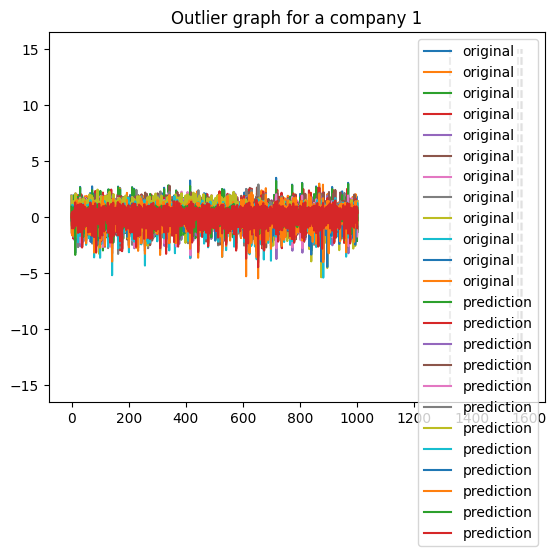

(1002, 12)

In [12]:
#plots for univariate
plt.plot(range(1002), data_test, label = "original")
plt.plot(range(1002), lstm_pred, label = "prediction")

distances = np.square(lstm_pred-data_test)
outliers  = np.argsort(distances.reshape(-1))[-4:]


for o in outliers:
    plt.plot([outliers]*100, np.linspace(-15,15,100), 'k--', alpha = 0.1)

plt.legend()
plt.title("Outlier graph for a company 1")
plt.show()

lstm_pred.shape

# Run LSTM for multivariate time series

In [8]:
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers, history = lstm_run(
    LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            64,
            64,
            128
        ], 
        mid_activation=tf.nn.tanh
    ),
    data_train_seq,
    data_test_seq,
    batch_size=512,
    epoch=300,
    metric="bb",
    early_stopping=False,
    cross_feature_check=True
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")

Epoch 1/300
3/3 [==============================] - 9s 98ms/step - loss: 1.1503
Epoch 2/300
3/3 [==============================] - 0s 84ms/step - loss: 1.1488
Epoch 3/300
3/3 [==============================] - 0s 72ms/step - loss: 1.1469
Epoch 4/300
3/3 [==============================] - 0s 76ms/step - loss: 1.1438
Epoch 5/300
3/3 [==============================] - 0s 79ms/step - loss: 1.1388
Epoch 6/300
3/3 [==============================] - 0s 78ms/step - loss: 1.1314
Epoch 7/300
3/3 [==============================] - 0s 74ms/step - loss: 1.1221
Epoch 8/300
3/3 [==============================] - 0s 78ms/step - loss: 1.1129
Epoch 9/300
3/3 [==============================] - 0s 74ms/step - loss: 1.1063
Epoch 10/300
3/3 [==============================] - 0s 77ms/step - loss: 1.0990
Epoch 11/300
3/3 [==============================] - 0s 74ms/step - loss: 1.0904
Epoch 12/300
3/3 [==============================] - 0s 73ms/step - loss: 1.0823
Epoch 13/300
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


32/32 [==============================] - 1s 5ms/step
Data test shape (1002, 12)
lstm_pred shape (1002, 12)


/Users/rohankulkarni/Desktop/Wellington/deep-learning-wellington-od/model/model_exec.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx = np.array([
/Users/rohankulkarni/Desktop/Wellington/deep-learning-wellington-od/model/model_exec.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


In [9]:
lstm_outliers[2].shape

(15,)

ValueError: x and y must have same first dimension, but have shapes (500,) and (300,)

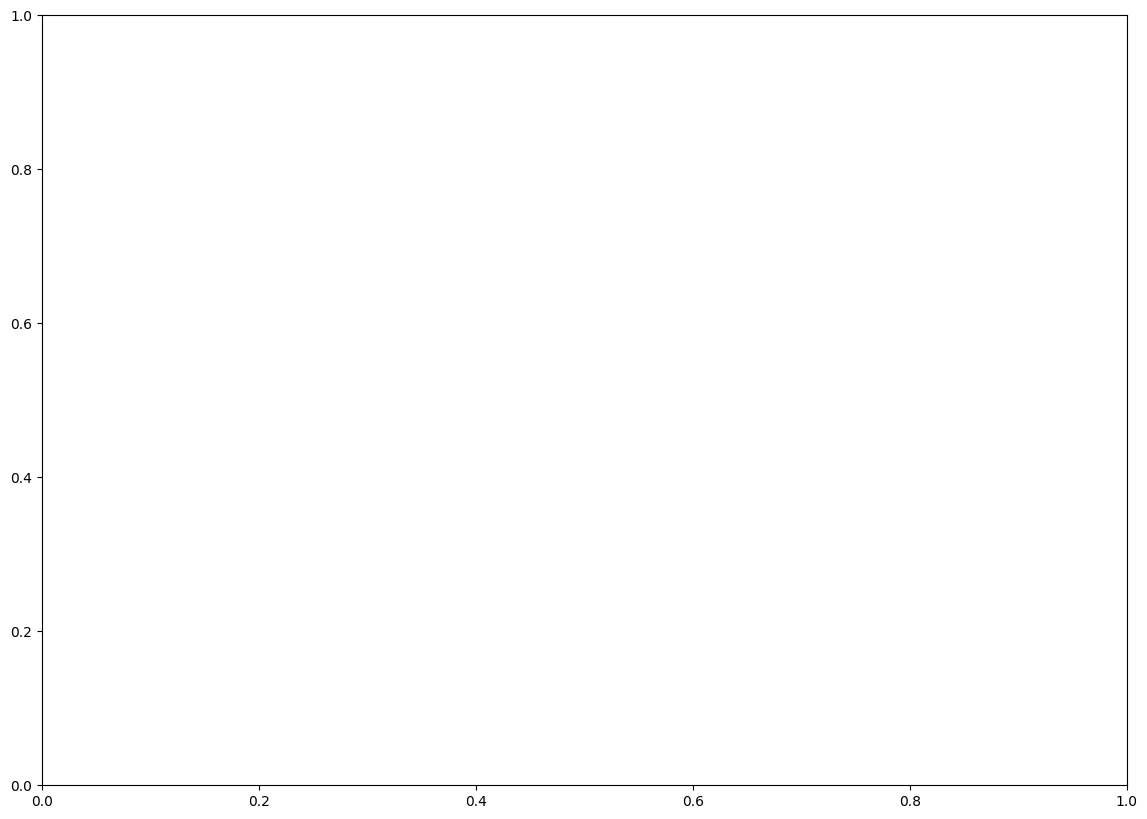

In [10]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
fig, ax = plt.subplots(1, 1, figsize = [14, 10])
ax.plot(np.arange(1, 501), loss)
ax.grid()

# Plotting

In [ ]:
lstm_outliers

array([array([ 24,  25,  32,  52,  59,  66,  68, 108, 109, 123, 136, 146, 228,
              229, 241, 257, 306, 326, 348, 487, 543, 598, 646, 698, 738, 794,
              873, 878, 962, 998])                                            ,
       array([ 11,  39,  46,  52,  74, 109, 110, 144, 145, 193, 214, 221, 248,
              257, 307, 332, 438, 440, 444, 515, 522, 620, 621, 634, 650, 651,
              669, 698, 733, 739, 768, 775, 782, 816, 817, 830, 865, 866, 881,
              963, 977])                                                      ,
       array([ 66,  82, 109, 110, 123, 124, 130, 131, 137, 138, 339, 752]),
       array([141, 340, 432, 603, 679]),
       array([ 25,  26,  53,  66,  67,  98, 108, 123, 124, 147, 161, 166, 221,
              230, 231, 245, 257, 299, 411, 417, 459, 460, 480, 487, 488, 535,
              543, 599, 605, 606, 642, 648, 652, 698, 708, 718, 734, 743, 757,
              774, 781, 792, 809, 810, 840, 853, 871, 875, 876, 949, 967, 998,
            

IndexError: index 1 is out of bounds for axis 1 with size 1

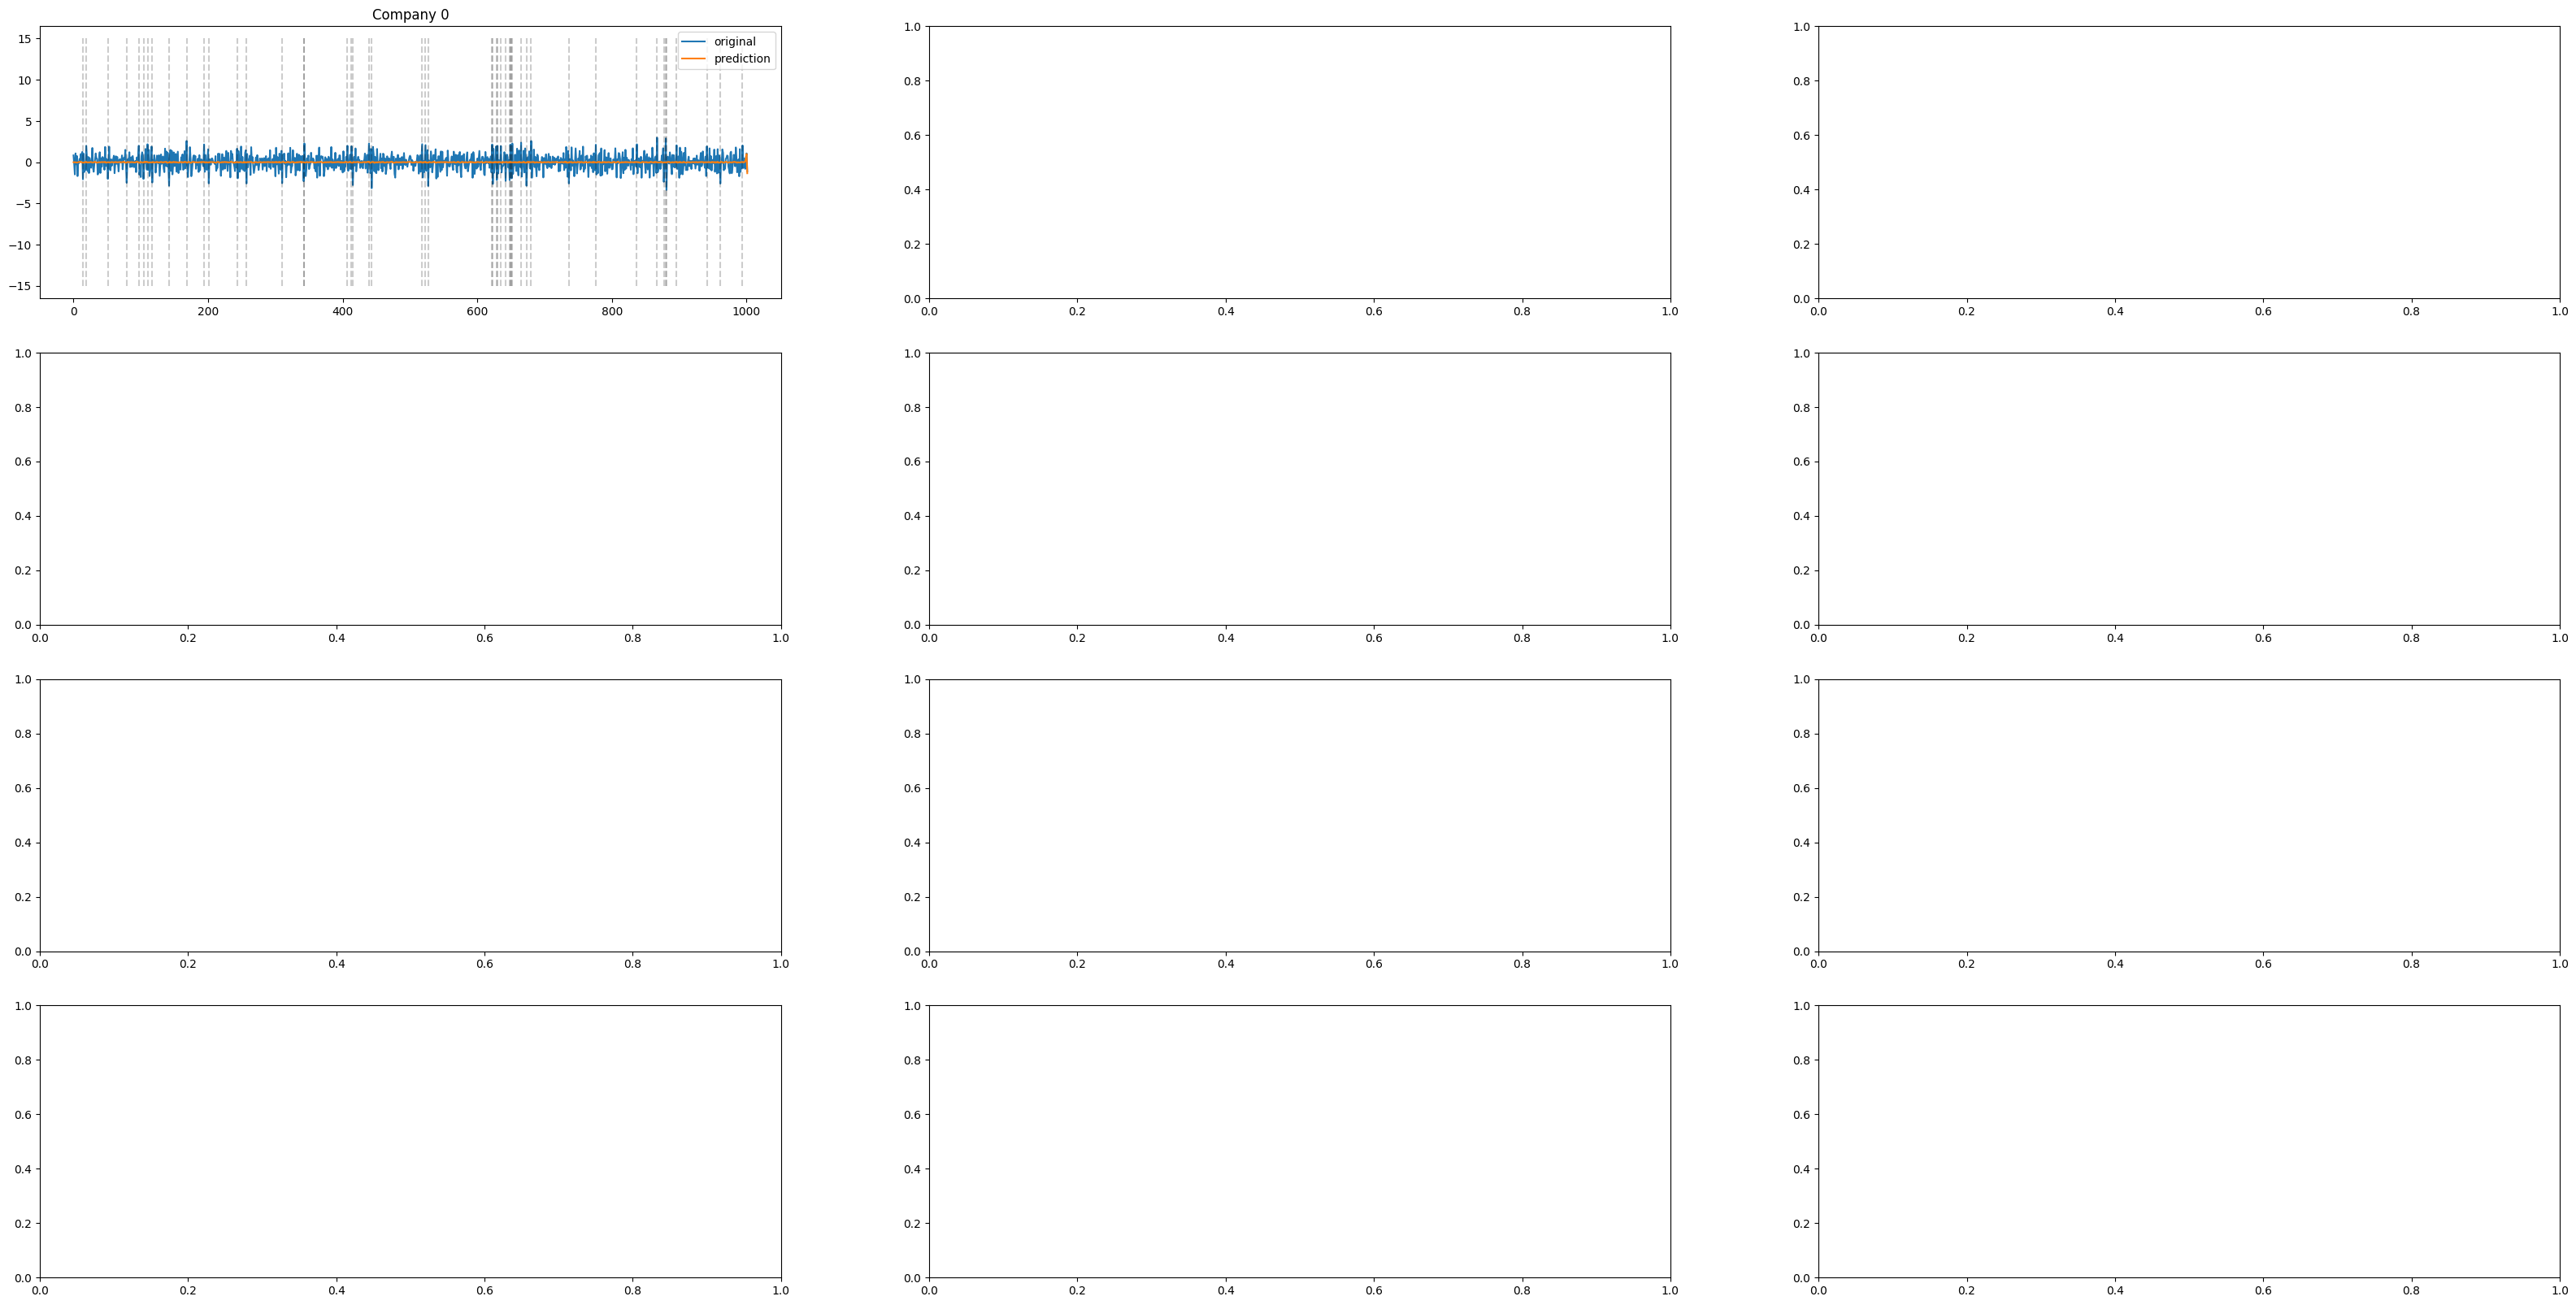

In [ ]:
rows = 4
cols = 3

figure, ax = plt.subplots(rows, cols, figsize=(40, 20))

for i in range(rows*cols):
    ax[i//cols][i % cols].plot(range(1002), data_test[:,i], label = "original")
    ax[i//cols][i % cols].plot(range(1002), lstm_pred[:,i], label = "prediction")
#   ax[i//cols][i % cols].grid()
    for o in lstm_outliers[i]:
        ax[i//cols][i % cols].plot([o]*100, np.linspace(-15,15,100), 'k--', alpha = 0.2)
    ax[i//cols][i % cols].set_title(f"Company {i}")
    ax[i//cols][i % cols].legend()
figure.suptitle("All Runs with pairwise_distance")    
    


/var/folders/g0/vly43npx24nf2s_dtjcp9lq80000gn/T/ipykernel_71966/3780426595.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax[i//cols][i % cols].plot([o]*100, np.linspace(-15,15,100), 'k--', color="green", alpha = 0.2)


Text(0.5, 0.98, 'All Runs with pairwise_distance_no_broadcast')

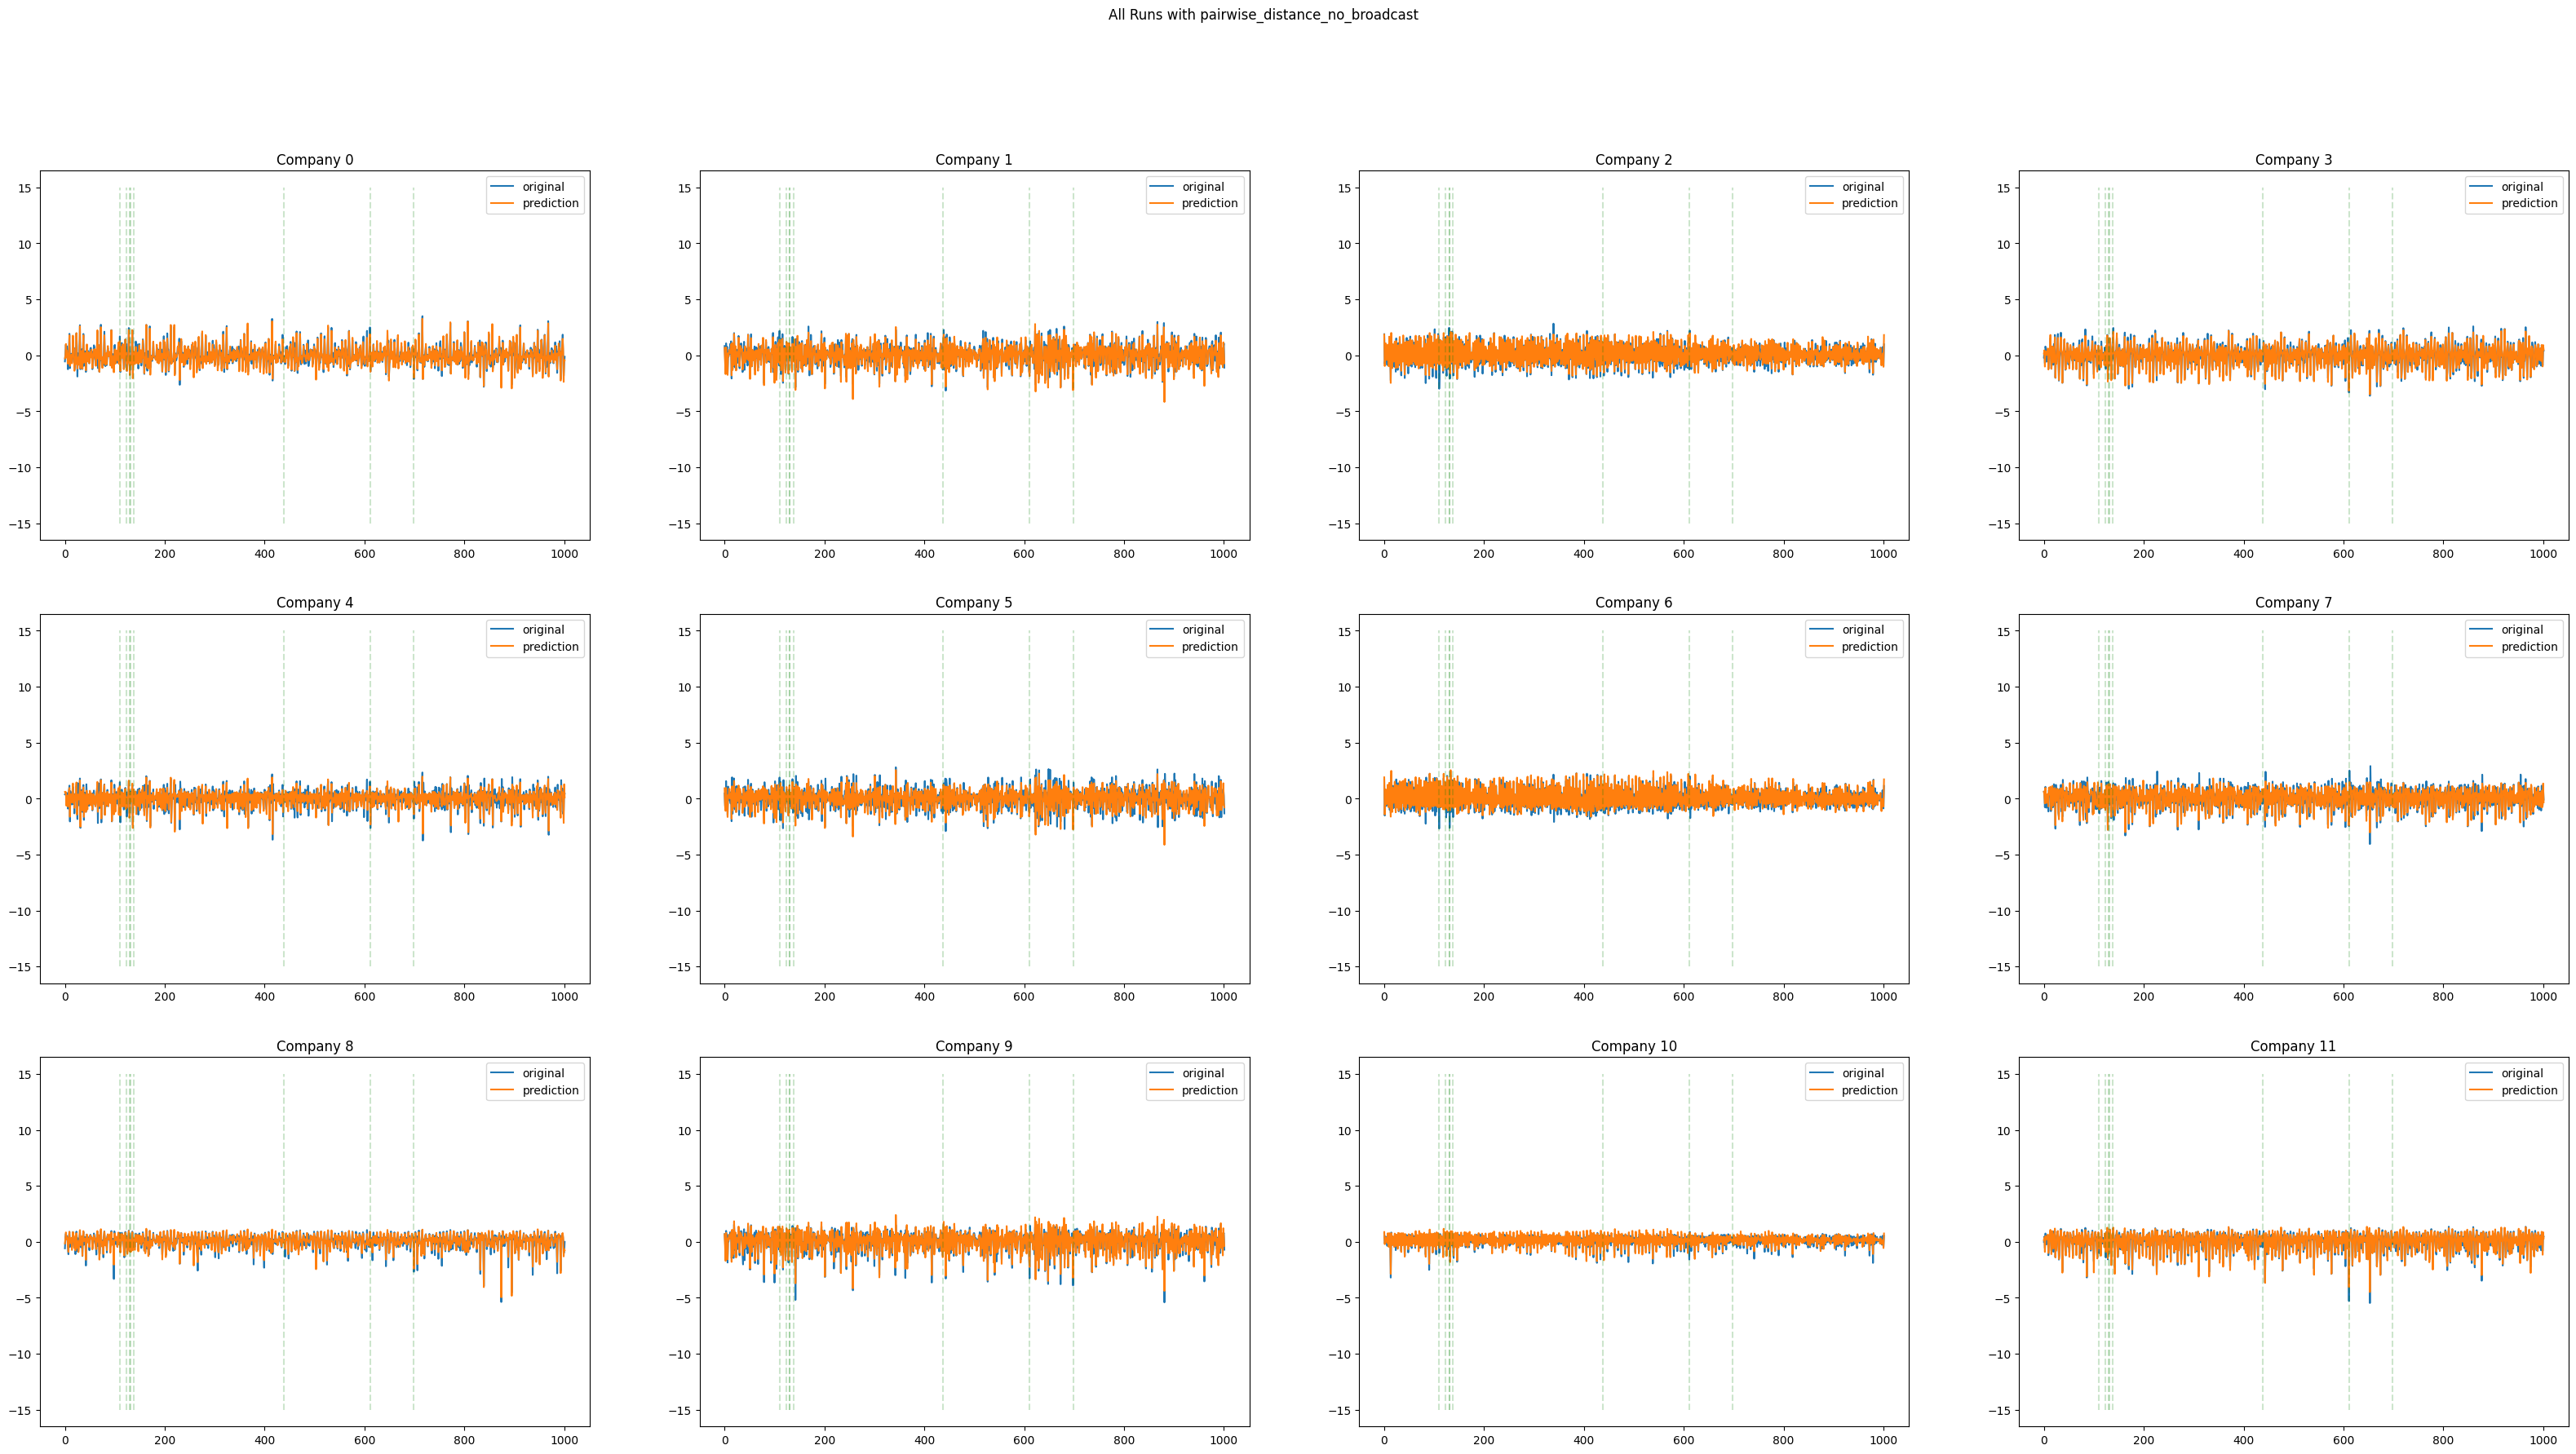

In [ ]:
distances = np.mean(np.square(lstm_pred-data_test),axis=1)
lstm_outliers  = np.argsort(distances.reshape(-1))[-8:]
lstm_outliers

rows = 3
cols = 4

figure, ax = plt.subplots(rows, cols, figsize=(40, 20))

for i in range(rows*cols):
    ax[i//cols][i % cols].plot(range(1002), data_test[:,i], label = "original")
    ax[i//cols][i % cols].plot(range(1002), lstm_pred[:,i], label = "prediction")
#   ax[i//cols][i % cols].grid()
    for o in lstm_outliers:
        ax[i//cols][i % cols].plot([o]*100, np.linspace(-15,15,100), 'k--', color="green", alpha = 0.2)
    ax[i//cols][i % cols].set_title(f"Company {i}")
    ax[i//cols][i % cols].legend()
figure.suptitle("All Runs with pairwise_distance_no_broadcast")  